In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from kf import *

In [2]:
class Goal: 
    def __init__(self, x, y, radius=0.3):
        self.pos = np.array([x, y]).T
        self.radius = radius
        
    def draw(self, ax, elems):
        x, y = self.pos
        c = ax.scatter(x + 0.16, y + 0.5, s=50, marker=">", label="landmarks", color="red") #旗
        elems.append(c)
        elems += ax.plot([x, x], [y, y + 0.6], color="black") #旗竿
        
    def inside(self, pose): ###puddleinside 
        return all([ self.lowerleft[i] < pose[i] < self.upperright[i]  for i in [0, 1] ])

In [3]:
class Puddle: 
    def __init__(self, lowerleft, upperright, depth):
        self.lowerleft = lowerleft
        self.upperright = upperright
        self.depth = depth
        
    def draw(self, ax, elems):
        w = self.upperright[0] - self.lowerleft[0]
        h = self.upperright[1] - self.lowerleft[1]
        r = patches.Rectangle(self.lowerleft, w, h, color="blue", alpha=self.depth)
        elems.append(ax.add_patch(r))
        
    def inside(self, pose): ###puddleinside 
        return all([ self.lowerleft[i] < pose[i] < self.upperright[i]  for i in [0, 1] ])

In [4]:
class PuddleWorld(World): ###puddleworld
    def __init__(self, time_span, time_interval, debug=False):
        super().__init__(time_span, time_interval, debug)
        self.puddles = []
        self.robots = []
        self.goals = []
        
    def append(self,obj):
        self.objects.append(obj)
        if isinstance(obj, Puddle): self.puddles.append(obj)
        if isinstance(obj, Robot): self.robots.append(obj)
        if isinstance(obj, Goal): self.goals.append(obj)
        
    def puddle_depth(self, pose):
        return sum([p.depth * p.inside(pose) for p in self.puddles])
    
    def one_step(self, i, elems, ax):
        super().one_step(i, elems, ax)
        for r in self.robots:
            r.agent.puddle_depth = self.puddle_depth(r.pose)

In [5]:
class PuddleIgnoreAgent(KfAgent): ###puddleingoreagent3
    def __init__(self, time_interval, nu, omega, kf, puddle_coef=100): #KfAgentのinitの引数にpuddle_coef追加
        super().__init__(time_interval, nu, omega, kf)
        
        self.puddle_coef = puddle_coef
        self.puddle_depth = 0.0
        self.total_reward = 0.0
        
    def reward_per_sec(self):
        return -1.0 - self.puddle_depth*self.puddle_coef

    def decision(self, observation=None):
        self.kf.motion_update(self.prev_nu, self.prev_omega, self.time_interval) 
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.kf.observation_update(observation)
        
        self.total_reward += self.time_interval*self.reward_per_sec()
        
        return self.nu, self.omega
        
    def draw(self, ax, elems): 
        super().draw(ax, elems)
        x, y, _ = self.kf.belief.mean
        elems.append(ax.text(x+1.0, y-0.5, "reward/sec:" + str(self.reward_per_sec()), fontsize=8))
        elems.append(ax.text(x+1.0, y-1.0, "total reward:" + "eval: {:.1f}".format(self.total_reward), fontsize=8))

<IPython.core.display.Javascript object>


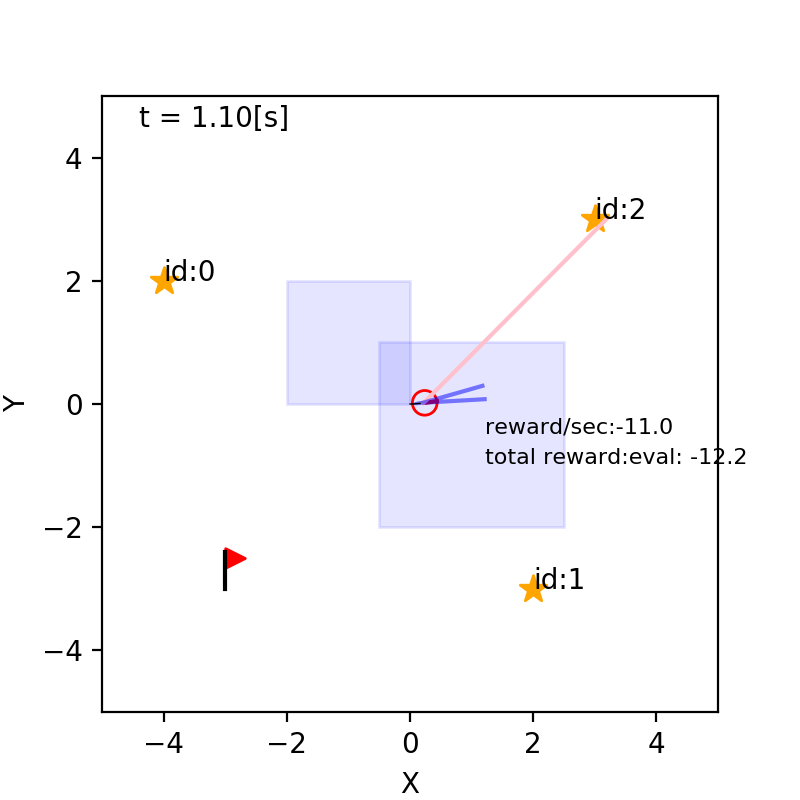

In [7]:
if __name__ == '__main__': ###puddleworld3exec
    time_interval = 0.1
    world = PuddleWorld(40, time_interval) #変更

    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ###ゴールの追加###
    world.append(Goal(-3,-3))
    
    ###水たまりの追加###
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1)) 

    ### ロボットを作る ###
    initial_pose = np.array([0,0,0]).T
    kf = KalmanFilter(m, initial_pose) #地図を引数で渡す
    a = PuddleIgnoreAgent(time_interval, 0.2, 10.0/180*math.pi, kf) 
    r = Robot(initial_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0), 
              agent=a, color="red", bias_rate_stds=(0,0))
    
    world.append(r)
    
    world.draw()